In [1]:
import gym
import torch
from darc import DARC
from sac import ContSAC
from broken_joint import BrokenJointEnv
import matplotlib.pyplot as plt
import numpy as np
from utils import *

env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

device = 'cuda'

state dim is: 17 and action dim is: 6


In [2]:
policy_config = {
    "input_dim": [state_dim],
    "architecture": [{"name": "linear1", "size": 128},
                     {"name": "linear2", "size": 128},
                     {"name": "split1", "sizes": [action_dim, action_dim]}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
value_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 128},
                     {"name": "linear2", "size": 128},
                     {"name": "linear2", "size": 1}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sa_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sas_config = {
    "input_dim": [state_dim * 2 + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}

# broken source

In [3]:
env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

state dim is: 17 and action dim is: 6


In [4]:
# set current device
torch.cuda.set_device(0)
device = 'cuda'

In [5]:
running_state = ZFilter((state_dim,), clip=10)
model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, "cuda", ent_adj=True,
             n_updates_per_train=1,lr=3e-4,max_steps=200,batch_size=256,
             savefolder='broken_source_half_cheetah_200steps_small_network)',running_mean=running_state,if_normalize = True)

src, tgt = model.train(5000, deterministic=False)

TARGET: index: 0, steps: 201, total_rewards: -3.2216527913263424
SOURCE: index: 0, steps: 201, total_rewards: -58.18762204401869
TARGET: index: 1, steps: 201, total_rewards: -78.7481250617062
SOURCE: index: 1, steps: 201, total_rewards: -89.75035302106917
TARGET: index: 2, steps: 201, total_rewards: -12.46647703067243
SOURCE: index: 2, steps: 201, total_rewards: -24.77734391544341
TARGET: index: 3, steps: 201, total_rewards: -91.36768754687957
SOURCE: index: 3, steps: 201, total_rewards: 6.935580617901398
TARGET: index: 4, steps: 201, total_rewards: -54.98257568751936
SOURCE: index: 4, steps: 201, total_rewards: -2.2166714189298276
TARGET: index: 5, steps: 201, total_rewards: -28.446438358283114
SOURCE: index: 5, steps: 201, total_rewards: -58.260574498881454
TARGET: index: 6, steps: 201, total_rewards: -49.44395689383428
SOURCE: index: 6, steps: 201, total_rewards: -67.56672817610708
TARGET: index: 7, steps: 201, total_rewards: -48.212903894234735
SOURCE: index: 7, steps: 201, total_r

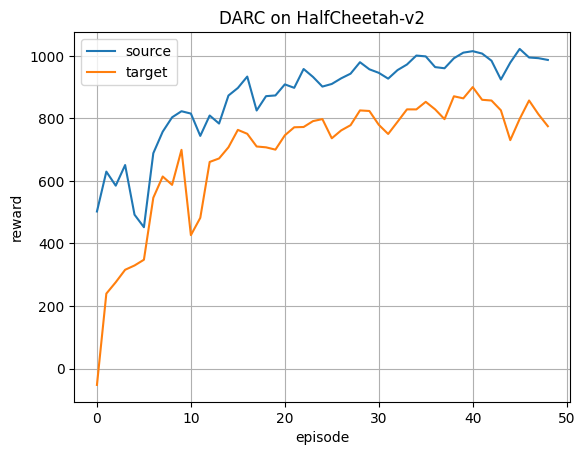

In [6]:
length = list(range(len(src)))
plt.plot(length, src, label="source")
plt.plot(length, tgt, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("DARC on HalfCheetah-v2")
plt.legend()
plt.grid()
plt.show()

# Sample Expert trajectory and save

In [5]:
import gym
import argparse
import numpy as np
from darc import DARC
from broken_joint import BrokenJointEnv
import os
import torch
from utils import *
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import sys
import pickle
import time
from src_gailsac_classifier import GailContSAC_SRC_Classifier

In [6]:
render = 'store_true'
log_std = -0.0
gamma = 0.99
tau = 0.95
lr_reg = 1e-3
learning_rate = 5e-5
clip_epsilon = 0.01
num_threads = 1
seed = 1
min_batch_size = 2048
eval_batch_size = 2048
max_iter_num = 15000
log_interval = 1
save_model_path = ''
max_expert_state_num = 1000
train_steps = 2000
episode_length = 200
save_file_name = ''
optim_epochs = 3


env_name = "HalfCheetah-v2"
env = gym.make(env_name)

def lr_decay(actor_optim,cirtic_optim, total_steps,max_steps):
    if total_steps > 7000:
        lr_a_now = learning_rate * (1 - (total_steps-7000) /(max_steps))
        for p in actor_optim.param_groups:
            p['lr'] = lr_a_now
        for p in cirtic_optim.param_groups:
            p['lr'] = lr_a_now
    return actor_optim,cirtic_optim



In [7]:
save_model = 'broken_source_half_cheetah_200steps_small_network/4900'


expert_model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, device, ent_adj=True,
             n_updates_per_train=1, max_steps = 200, batch_size=256, savefolder ='none') 
expert_model.load_model(save_model, device)
expert_model.running_mean.fix = True


In [8]:
num_steps = 0
expert_traj = []
total_reward = 0
from tqdm import tqdm

for i_episode in tqdm(range(100000)):

    state = source_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0

    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = source_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1

        expert_traj.append(np.hstack([state, next_state]))
        

        if done or num_steps >= max_expert_state_num:
            break


        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode

    # print('Episode {}\t reward: {:.2f} \t step : {}'.format(i_episode, reward_episode,t))
print('eval on src',total_reward/(i_episode))
expert_traj = np.stack(expert_traj)

total_reward = 0
num_steps = 0
for i_episode in tqdm(range(50)):
    state = target_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0
    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = target_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
print('eval on tgt',total_reward/(i_episode))

  0%|          | 4/100000 [00:00<4:31:26,  6.14it/s]


eval on src 1114.4859731762267


  8%|▊         | 4/50 [00:00<00:05,  8.39it/s]

eval on tgt 973.5081362952553


In [9]:
IL = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 0.2, update_freq = 50,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs, tgt_bs, classifier_loss = IL.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -66.34486701451821, total_reward_adv: -42.3601, acc gen: 0, acc expert: 0
eval reward: -0.5447068512014595
index: 1, steps: 201, total_rewards: 5.416347351600271, total_reward_adv: -21.1405, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -86.04216016008999, total_reward_adv: -59.8408, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: 22.715261210662646, total_reward_adv: 31.5013, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -13.778661244122803, total_reward_adv: -7.5219, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -0.9832808291237248, total_reward_adv: -7.3194, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -31.178354288895328, total_reward_adv: -12.9567, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: 4.1795876287340334, total_reward_adv: 11.5163, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -34.98582299975815, total_reward_adv: -20.85

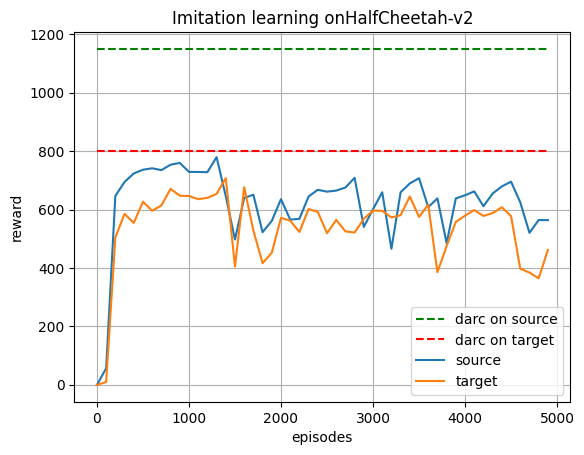

In [10]:
length = np.array(list(range(len(src_bs)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs, label="source")
plt.plot(length, tgt_bs, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


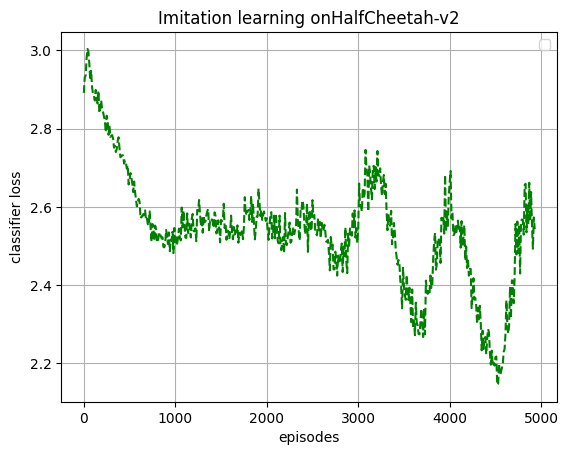

In [11]:
loss_length = np.array(list(range(len(classifier_loss)))) * 10
plt.plot(loss_length, classifier_loss, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [12]:
IL_2 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 0.2, update_freq = 1000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_2, tgt_bs_2, classifier_loss_2 = IL_2.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -68.01778628335681, total_reward_adv: -15.1276, acc gen: 0, acc expert: 0
eval reward: -0.8832087370302792
index: 1, steps: 201, total_rewards: -118.46465043216925, total_reward_adv: -54.677, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -83.06008481179522, total_reward_adv: -28.4896, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -26.145819973777474, total_reward_adv: 14.8662, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -105.25629663353313, total_reward_adv: -45.9319, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -59.604386954715956, total_reward_adv: -7.7996, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -46.40606677377823, total_reward_adv: 0.9919, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -12.774088052420483, total_reward_adv: 28.6253, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -10.139993769459876, total_reward_adv: 27.5

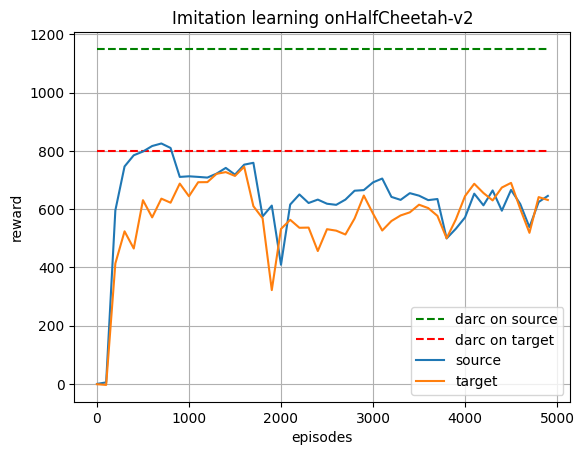

In [13]:
length = np.array(list(range(len(src_bs_2)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_2, label="source")
plt.plot(length, tgt_bs_2, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


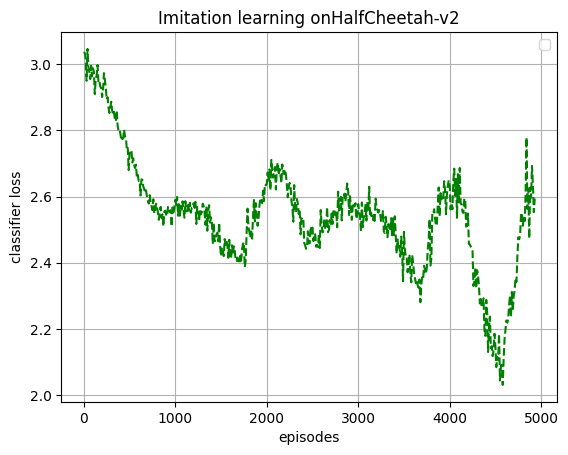

In [15]:
loss_length_2 = np.array(list(range(len(classifier_loss_2)))) * 10
plt.plot(loss_length_2, classifier_loss_2, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [16]:
IL_3 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 0.2, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, 
                                    clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_3, tgt_bs_3, classifier_loss_3 = IL_3.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -22.558337158869058, total_reward_adv: 34.7736, acc gen: 0, acc expert: 0
eval reward: -1.1829958056978387
index: 1, steps: 201, total_rewards: -3.237777804827504, total_reward_adv: 62.5271, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: 14.924139067828738, total_reward_adv: 60.5935, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: 1.684084762263748, total_reward_adv: 62.395, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: 12.843455807639913, total_reward_adv: 69.6636, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -3.3779583925689867, total_reward_adv: 53.5611, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -96.49217642919442, total_reward_adv: -18.147, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -18.583213001175388, total_reward_adv: 33.694, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -54.75052550267214, total_reward_adv: 8.6624, acc 

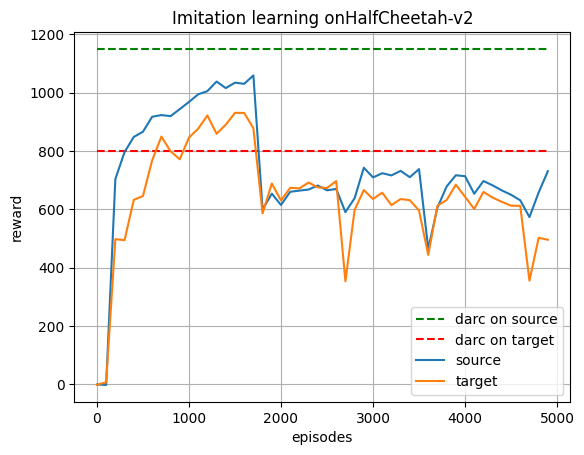

In [17]:
length = np.array(list(range(len(src_bs_3)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_3, label="source")
plt.plot(length, tgt_bs_3, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


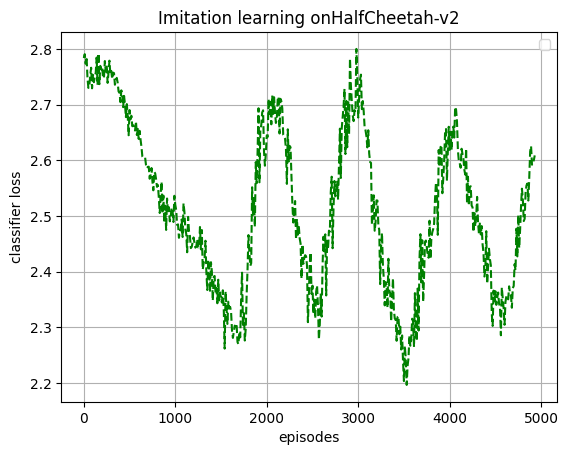

In [18]:
loss_length_3 = np.array(list(range(len(classifier_loss_3)))) * 10
plt.plot(loss_length_3, classifier_loss_3, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [21]:
IL_4 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, 
                                    clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_4, tgt_bs_4, classifier_loss_4 = IL_4.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -55.72139774759229, total_reward_adv: -19.3496, acc gen: 0, acc expert: 0
eval reward: -0.9831445607842261
index: 1, steps: 201, total_rewards: 21.163756263259664, total_reward_adv: 43.9161, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -11.75172257102507, total_reward_adv: 9.004, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -43.35249572331072, total_reward_adv: -0.8935, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -35.807794747048774, total_reward_adv: 11.9538, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -47.87700606911446, total_reward_adv: -16.9698, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -72.07051537453495, total_reward_adv: -32.9138, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -32.22274953885278, total_reward_adv: -5.3545, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -33.32303178959449, total_reward_adv: -4.6865, a

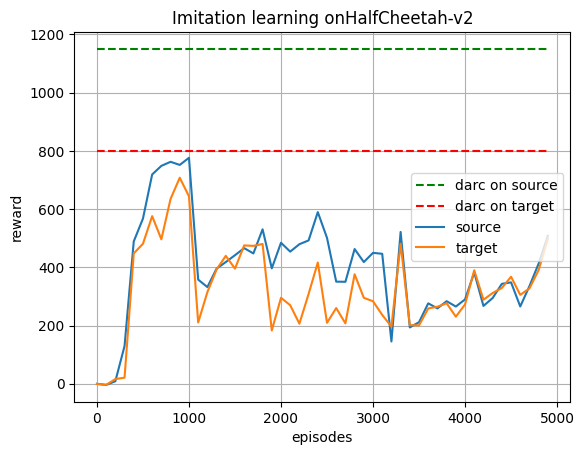

In [22]:
length = np.array(list(range(len(src_bs_4)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_4, label="source")
plt.plot(length, tgt_bs_4, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


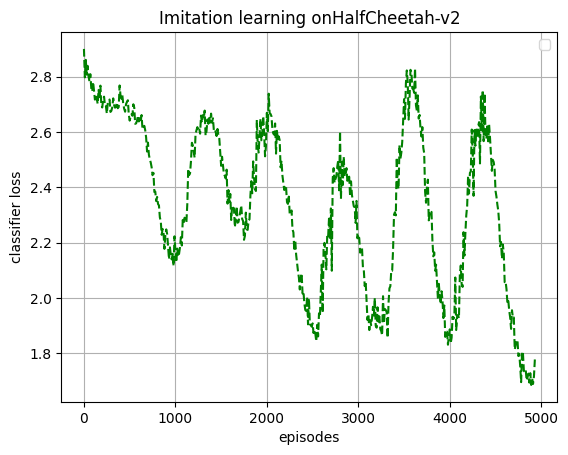

In [23]:
loss_length_4 = np.array(list(range(len(classifier_loss_4)))) * 10
plt.plot(loss_length_4, classifier_loss_4, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [24]:
IL_5 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, 
                                    clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_5, tgt_bs_5, classifier_loss_5 = IL_5.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -37.81594492620226, total_reward_adv: -114.4688, acc gen: 0, acc expert: 0
eval reward: -0.5142905170993112
index: 1, steps: 201, total_rewards: -78.21769255274975, total_reward_adv: -172.7766, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -58.512579294074264, total_reward_adv: -147.5249, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -86.44053686867089, total_reward_adv: -186.9667, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -130.6205271958101, total_reward_adv: -250.4046, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: 7.9556160684376405, total_reward_adv: -46.7395, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -68.24816539606475, total_reward_adv: -161.8854, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -4.444475969031307, total_reward_adv: -78.7513, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -56.26237632019972, total_reward_ad

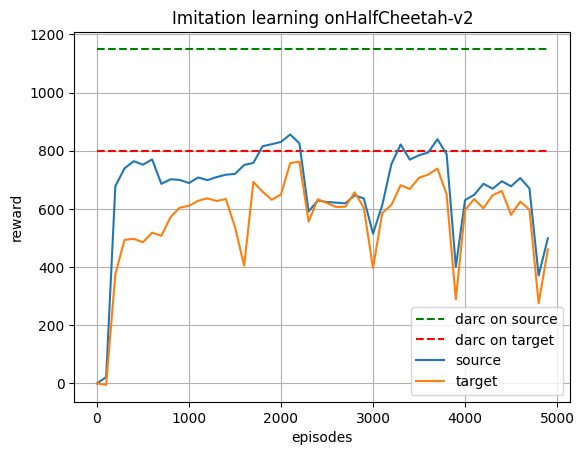

In [25]:
length = np.array(list(range(len(src_bs_5)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_5, label="source")
plt.plot(length, tgt_bs_5, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()